In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.morphology import remove_small_holes, area_opening, skeletonize
import pandas as pd
from matplotlib import rcParams
from scipy.interpolate import interp1d

THRESHOLD = 120
MAX_PIXEL_VALUE = 255
MM2_CALIBRATION = 1000*(924)*1e-6  #largo*(diametro) de la cabecilla [µm^2 -> mm^2]

COLOR = 'black'
plt.style.use("default")
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams['figure.figsize'] = (28, 18)
rcParams['figure.titlesize'] = 20
rcParams['figure.dpi'] = 50
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = 'lightgray'
rcParams['legend.fontsize'] = 25
rcParams['axes.titlesize'] = 60
rcParams['axes.labelsize'] = 50
rcParams['ytick.labelsize'] = 20
rcParams['xtick.labelsize'] = 20
rcParams['text.color'] = COLOR
rcParams['text.color'] = COLOR
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR
rcParams['grid.color'] = COLOR
rcParams['text.latex.preamble'] = "\n".join([
    r'\usepackage[version=3]{mhchem}'
])

### funciones que se usan

In [2]:
def cortar(frame, limites, PRUEBA=False, nombre='CORTE'):
    # lee en gris
    min_x, max_x, min_y, max_y = limites
    corte = frame[min_y:max_y, min_x:max_x] # resolver lo del corte binarizadp
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', corte)
    return corte

def gris(frame, PRUEBA=False, nombre='GRAYSCALE'):
    im_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_gray)
    return im_gray

def binarize(frame, PRUEBA=False, nombre='BINARY', threshold = THRESHOLD):
    # im_binary = cv.adaptiveThreshold(frame, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
    _, im_binary = cv.threshold(frame, threshold, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_binary)
    return im_binary

def find(frame):
    y, x = np.where(frame==0)
    x_head = np.min(x)
    filas = np.unique(y)
    y_head = int(np.mean(filas))
    return x, y, x_head, y_head

def tracker(vs, limites, SHOW=False):
        # Crea las listas vacias que van a ser nuestras mediciones
        pos_x = []
        pos_y = []
        
        frame_count = vs.get(7)
        tiempo = [f for f in range(1, int(frame_count))]
        i=0
        while(vs.isOpened()):
            i+=1
            ret, frame = vs.read()

            if ret:
                frame = cortar(frame, limites)
                frame_bn = binarize(gris(frame))
                mask = frame_bn>0
                frame_bn = remove_small_holes(mask,10)*255
                try:
                    x, y, x_head, y_head = find(frame_bn)
                    pos_x.append(x_head)
                    pos_y.append(y_head)
                    if SHOW:
                        frame[y, x] = [0, 255, 0]
                        frame = cv.circle(frame, (x_head, y_head), radius=1, color=(0, 0, 255), thickness=-1)
                        cv.imshow('frame', frame)
                except:
                    break
                if cv.waitKey(1) & 0xFF == ord('q'):
                    break
            else:
                break
        cv.destroyAllWindows()
        # video.release()
        return np.array(tiempo), np.array(pos_x), np.array(pos_y)

def guillotina(frame, PRUEBA=False, nombre='DECAPITADO'):
    y, x = np.where(frame<=130)
    frame[y, x] = np.max(frame)
    frame -= np.min(frame)
    frame = (frame/np.max(frame))*255
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', frame)
    return frame

def binarize_TAIL(frame, PRUEBA=False, nombre='BINARY_TAIL'):
    _, im_binary = cv.threshold(
        src=frame,
        thresh=THRESHOLD - 20,
        maxval=MAX_PIXEL_VALUE,
        type=cv.THRESH_BINARY)
    
    bool_mask = im_binary > 0 #im_binary contains only 0's and 1's, so this is a mask where all the 0's are false and all the 1's are true.
    im_binary = remove_small_holes(bool_mask)*255
    #im_binary = area_opening(im_binary, 200)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_binary)
    return im_binary

def skeleton(frame, PRUEBA=False, nombre='ESQUELETO'):
    arr = frame < 255 #Convert frame to binary mask of 1's and 0's
    sk = skeletonize(arr)*255 #We apply skeletonize to boolean mask and upscale 1's to 255 (white)
    _, x = np.where(sk!=0)
    # esto cierra los globitos, es lo que faltaba antes:
    for c in np.unique(x):
        r = np.where(sk[:, c]!=0)[0]
        for p in r:
            sk[p, c] = 0
        sk[int(np.mean(r)), c] = 255
    tail = np.where(sk!=0)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', sk)
    return sk, tail

def track_end_of_tail(vs, lim, SHOW=False):
    frame_count = vs.get(7)
    tiempo = [f for f in range(1, int(frame_count))]

    pos_end_tail_x = []
    pos_end_tail_y = []

    while(vs.isOpened()):
        ret, frame = vs.read()
        if ret:
            frame = cortar(frame, lim)
            
            last_column = frame[:, -2:-1]
            first_column = frame[:, 0:1]
            left_limit = cv.bitwise_not(binarize(first_column, threshold=140)) #140 works for most
            right_limit = cv.bitwise_not(binarize(last_column, threshold=140))

            if np.sum(left_limit) == 0 and np.sum(right_limit)==0:
                frame_bn = binarize_TAIL(guillotina(gris(frame)))
                _, tail = skeleton(frame_bn)
                x_sk = tail[1]
                y_sk = tail[0]
                
                if x_sk.size>0 and y_sk.size>0:
                    index_x_end_sk = np.argmax(x_sk)
                    x_end = x_sk[index_x_end_sk]
                    y_end = y_sk[index_x_end_sk]
                else:
                    x_end = None
                    y_end = None
                
                pos_end_tail_x = np.append(pos_end_tail_x, x_end)
                pos_end_tail_y = np.append(pos_end_tail_y, y_end)
                if SHOW:
                    frame[y_sk, x_sk] = [0, 0, 255]
                    cv.imshow('frame', frame)
                if cv.waitKey(1) & 0xFF == ord('q'):
                    break
            else:
                continue
        else:
            break
    cv.destroyAllWindows()
    i_stop = min(len(tiempo),len(pos_end_tail_x),len(pos_end_tail_y))    
    return np.array(tiempo[:i_stop]), np.array(pos_end_tail_x[:i_stop]), np.array(pos_end_tail_y[:i_stop])

def track_tail(vs, lim, SHOW=False):
    frame_count = vs.get(7)
    tiempo = [f for f in range(1, int(frame_count))]

    pos_sk = np.empty(len(tiempo), dtype=object)
    pos_tail = np.empty(len(tiempo), dtype=object)
    i=0
    while(vs.isOpened()):
        ret, frame = vs.read()
        if ret:            
            frame = cortar(frame, lim)
            last_column = frame[:, -2:-1]
            first_column = frame[:, 0:1]
            left_limit = cv.bitwise_not(binarize(first_column, threshold=140)) #140 works for most
            right_limit = cv.bitwise_not(binarize(last_column, threshold=140))

            if np.sum(left_limit) == 0 and np.sum(right_limit)==0:
                frame_bn = binarize_TAIL(guillotina(gris(frame)))
                sk, tail = skeleton(frame_bn)
                
                if tail:
                    pos_sk[i] = sk
                    pos_tail[i] = tail
                else:
                    continue
                if SHOW:
                    frame[tail[0],tail[1]] = [0, 0, 255]
                    cv.imshow('frame', frame)
                if cv.waitKey(1) & 0xFF == ord('q'):
                    break
            else:
                continue
            i+=1
        else:
            break
        
    cv.destroyAllWindows()
    return np.array(tiempo[:i]), np.array(pos_sk[:i]), np.array(pos_tail[:i])

### Prueba de una sola imagen

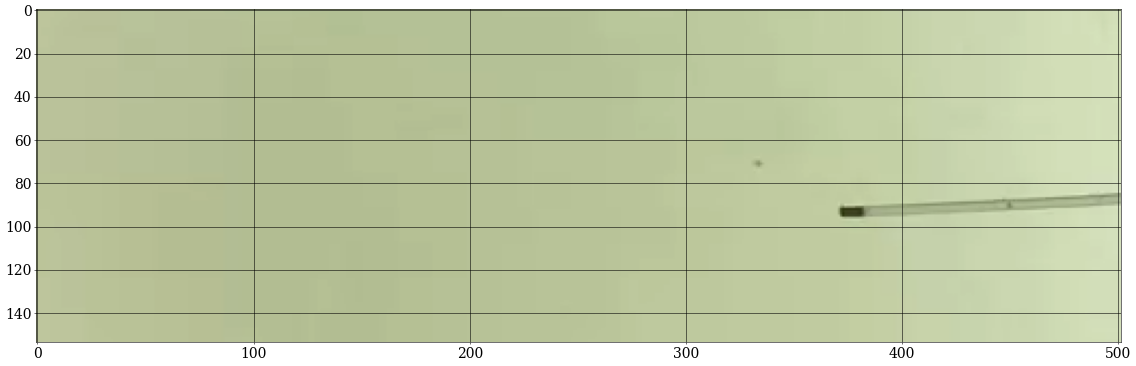

In [11]:
im = cv.imread('test-image.png')
plt.imshow(im)

#### Probando calibración en una sola imagen

El número de pixeles oscuros es: 51
Por lo tanto el mm2 por píxel es: 0.018117647058823527


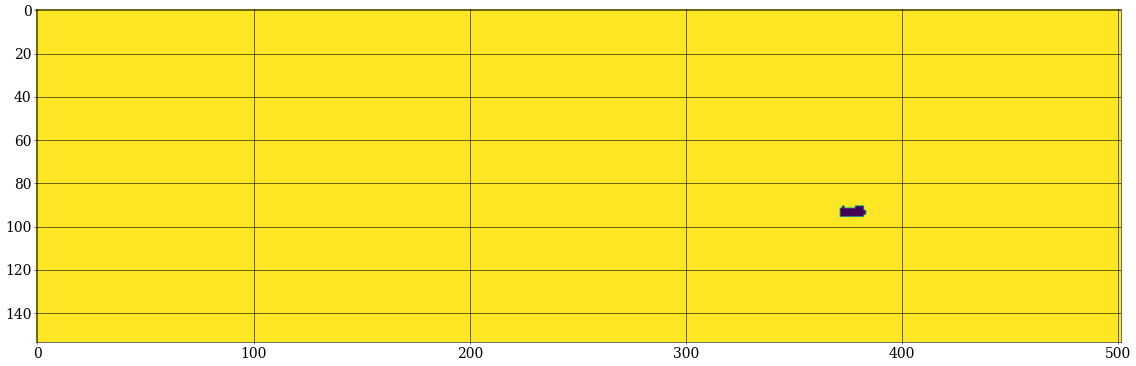

In [37]:
im_gray = gris(im)
im_binary = binarize(im_gray)
mask = im_binary>0
im_binary = remove_small_holes(mask,10)*255
plt.imshow(im_binary)
number_of_pixels = im_binary[im_binary==0].size
print(f'El número de pixeles oscuros es: {number_of_pixels}')

mm2_per_px = MM2_CALIBRATION / number_of_pixels
print(f'Por lo tanto el mm2 por píxel es: {mm2_per_px}')

#### Encontrando cabeza en imagen

383

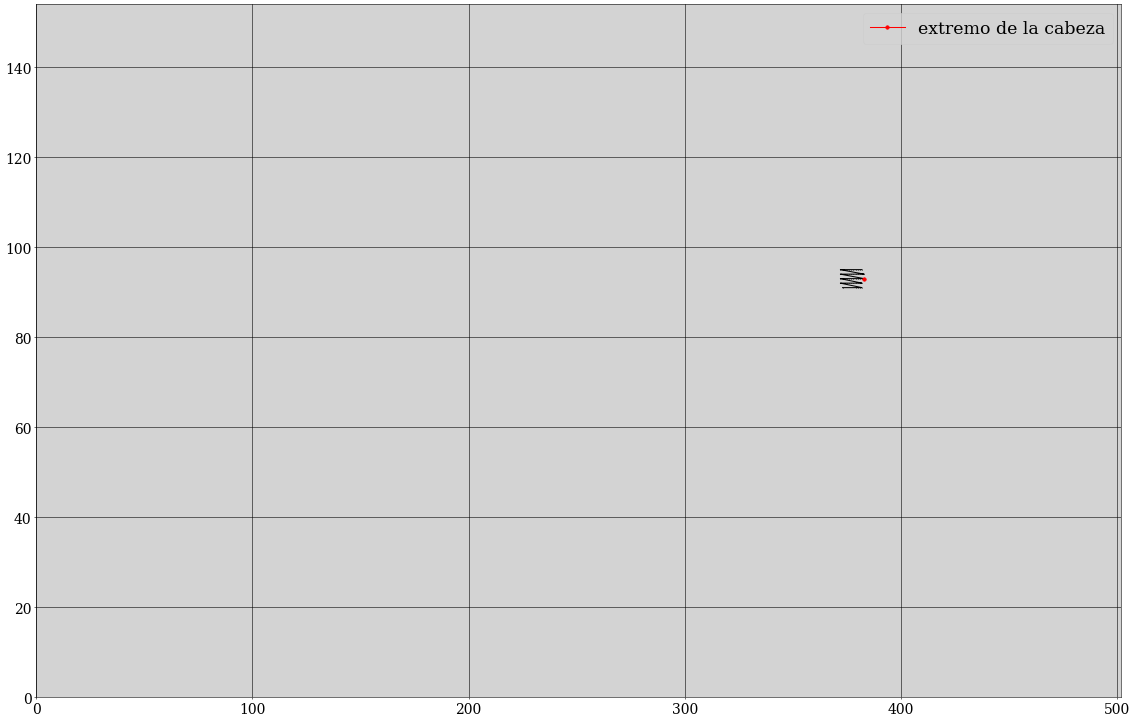

In [40]:
y, x = np.where(im_binary==0)
x_head = np.max(x)
filas_2 = np.unique(y)
y_head = int(np.mean(filas_2))

fig, ax = plt.subplots()
ax.set_xlim(0, len(im_binary[0]))
ax.set_ylim(0, len(im_binary))

ax.plot(x, y, color = 'k', marker='.', markersize=0.5)
ax.plot(x_head, y_head, color = 'r', marker='.', markersize=10, label='extremo de la cabeza')
ax.legend()
x_head

#### Prueba de blur

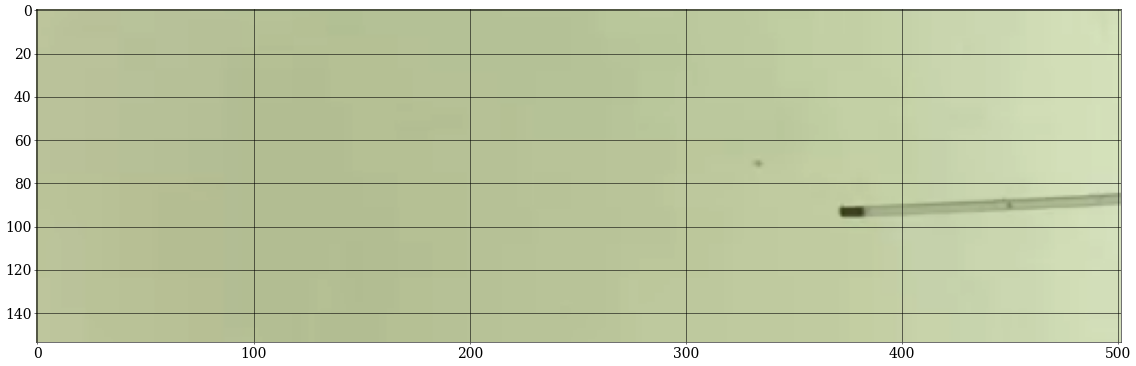

In [50]:
im = cv.imread('test-image.png')
frame = cv.GaussianBlur(src=im, ksize=(3,3), sigmaX=.5)
plt.imshow(frame)

### Pruebas de un solo video

In [39]:
# abro y analizo video
video = cv.VideoCapture('videos/ECO20-45mm-2,00Vpp-7,33Hz.mp4')
lim = [319, 1000, 250, 505] #[xleft, xright, ytop, ydown]
t,x,y = tracker(video, lim, SHOW=True)

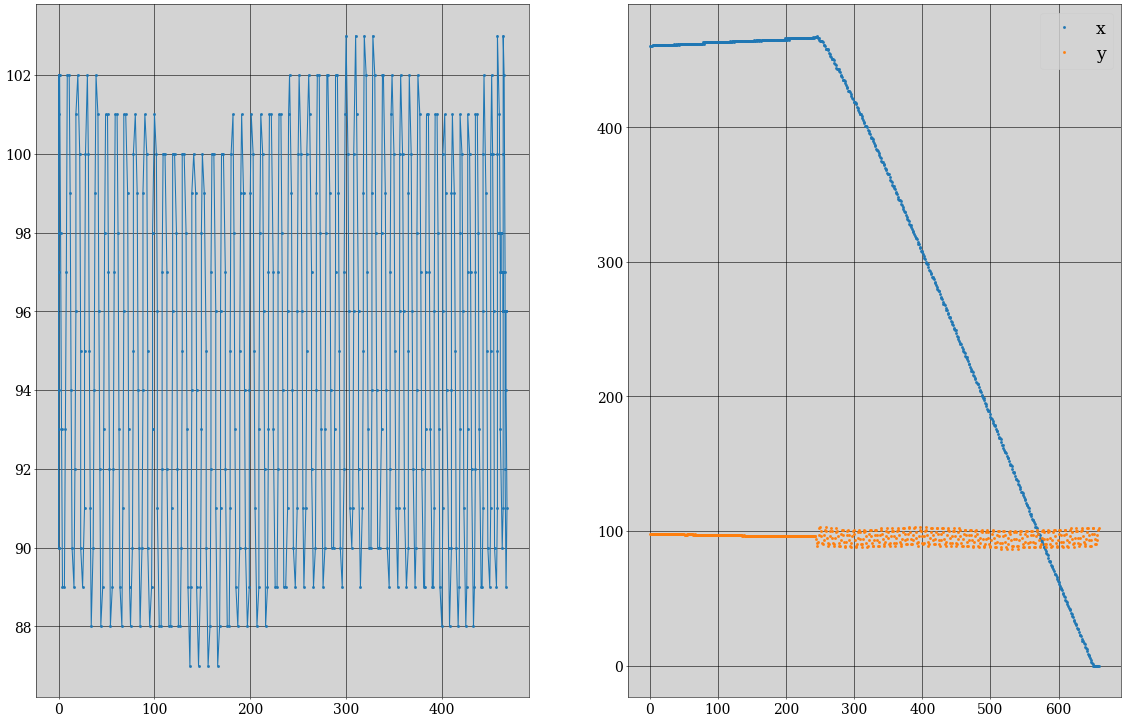

In [46]:
fig, [ax1, ax2] = plt.subplots(1, 2)
ax1.plot(x, y, '.-')

ax2.plot(t[:len(x)], x, '.',label='x')
ax2.plot(t[:len(x)], y, '.', label='y')
ax2.legend()

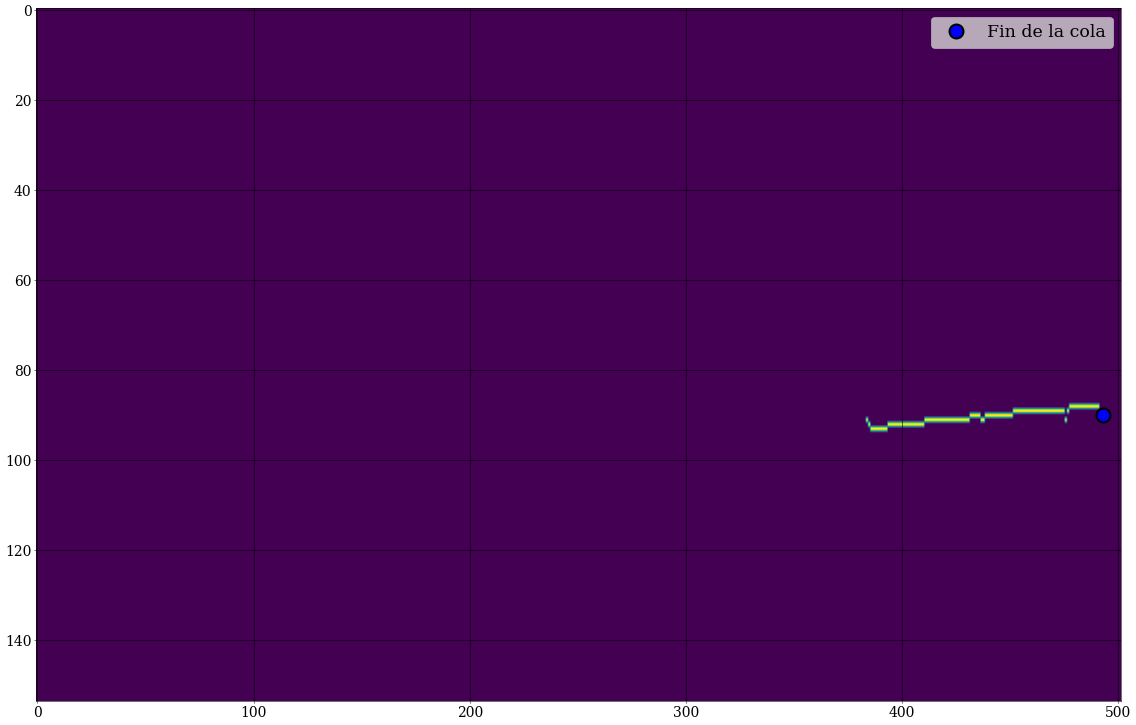

In [3]:
im = cv.imread('./test-image.png')
im_cut = im #cortar(im, limites=lim)
im_gray = gris(im_cut)
im_decap = guillotina(im_gray, PRUEBA=False)
im_binary = binarize_TAIL(im_decap, PRUEBA=False)
sk, tail = skeleton(im_binary, PRUEBA=False)

index_x_end_sk = np.argmax(tail[1])
x_end = tail[1][index_x_end_sk]
y_end = tail[0][index_x_end_sk]

plt.imshow(sk, aspect='auto')
plt.plot(x_end, y_end, color='b', marker='o',markersize=20, label='Fin de la cola', markeredgecolor='k', lw=0, markeredgewidth=3)
plt.legend()

In [73]:
video = cv.VideoCapture('videos/ECO20-45mm-1,50Vpp-7,33Hz.mp4')
lim = [319, 950, 250, 505]
# Crea las listas vacias que van a ser nuestras mediciones
frame_count = video.get(7)
tiempo = [f for f in range(1, int(frame_count))]

pos_end_tail_x = []
pos_end_tail_y = []

while(video.isOpened()):
    ret, frame = video.read()
    if ret:
        frame = cortar(frame, lim)
        frame_bn = binarize_TAIL(guillotina(gris(frame)))
        try:
            x_sk, y_sk = skeleton(frame_bn)

            index_x_end_sk = np.argmax(x_sk)
            x_end = x_sk[index_x_end_sk]
            y_end = y_sk[index_x_end_sk]
            pos_end_tail_x = np.append(pos_end_tail_x, x_end)
            pos_end_tail_y = np.append(pos_end_tail_y, y_end)
            frame[y_sk, x_sk] = [0, 0, 255]
            cv.imshow('frame', frame)
        except:
            break
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cv.destroyAllWindows()

### prueba de video de cola

In [7]:
# abro y analizo video
video = cv.VideoCapture('videos/ECO20-45mm-2,50Vpp-7Hz.mp4')
lim = [310, 950, 250, 505] #[xleft, xright, ytop, ydown]
t,x,y = track_end_of_tail(video, lim, SHOW=True)

### Chequeo de calibración en un solo video

Promedio de calibración: 56.73619309982947 pm 4.445343325478998 px/mm^2


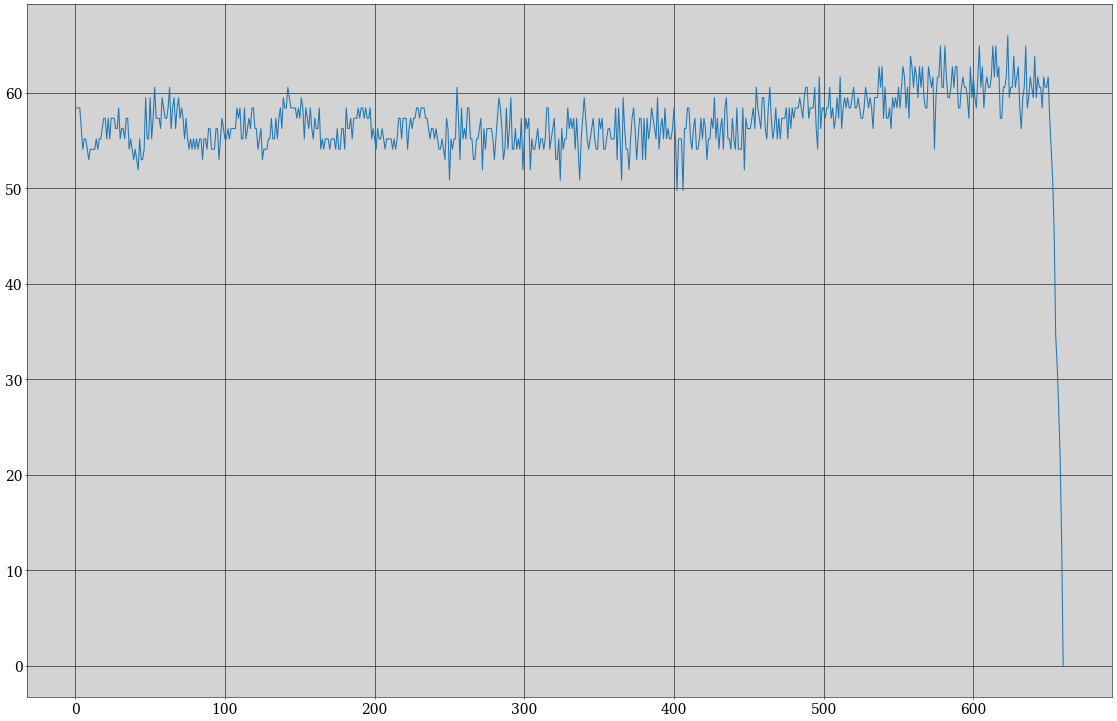

In [52]:
vs = cv.VideoCapture('videos/ECO20-45mm-1,50Vpp-7,33Hz.mp4')
lim = [319, 950, 250, 505]

# Crea las listas vacias que van a ser nuestras mediciones
pos_x = []
pos_y = []
calibracion = []

frame_count = vs.get(7)
tiempo = [f for f in range(1, int(frame_count))]

while(vs.isOpened()):
    ret, frame = vs.read()

    if ret:
        frame = cortar(frame, lim)
        frame_bn = binarize(gris(frame))
        mask = frame_bn>0
        frame_bn = remove_small_holes(mask,10)*255
        number_of_pixels = frame_bn[frame_bn==0].size
        px_per_mm2 = number_of_pixels / MM2_CALIBRATION #number_of_pixels puede ser 0 entonces tomamos px_per_mm2
        calibracion.append(px_per_mm2)
        try:
            x, y, x_head, y_head = find(frame_bn)
            pos_x.append(x_head)
            pos_y.append(y_head)
            if True:
                frame[y, x] = [0, 255, 0]
                frame = cv.circle(frame, (x_head, y_head), radius=1, color=(0, 0, 255), thickness=-1)
                cv.imshow('frame', frame)
        except:
            break
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cv.destroyAllWindows()
plt.plot(tiempo[:len(calibracion)],calibracion)

print(f'Promedio de calibración: {np.mean(calibracion)} pm {np.std(calibracion)} px/mm^2')

### Prueba de video de la forma de la cola

In [4]:
# abro y analizo video
PX_PER_MM = 7.532343134764206
FRAME_PER_SECOND = 60

video = cv.VideoCapture('videos/ECO20-45mm-2,50Vpp-3Hz.mp4')
lim = [310, 950, 250, 505] #[xleft, xright, ytop, ydown]
t, sk, tail_xy = track_tail(video, lim, SHOW=True)

In [5]:
plate = np.array([np.zeros((sk[0].shape[0],sk[0].shape[1])) for i in t]) #We create an empty canvas for our data
for i in np.arange(len(t)):
    tail = tail_xy[i]
    tail_x = tail[1] - np.min(tail[1]) #We remove the smallest index to make it start on 0
    tail_y = tail[0] - np.min(tail[0])
    plate[i][tail_y + 30,tail_x] = 1 #We arbitrarily add 30 so our data looks nicer

(90.0, 0.0)

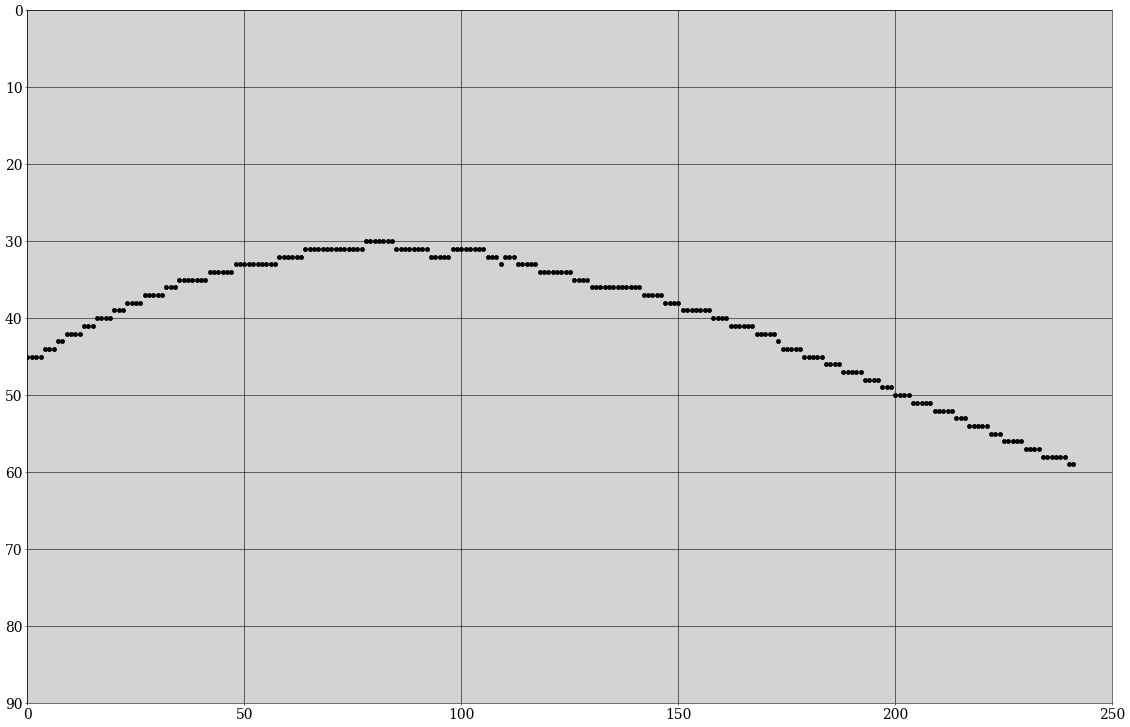

In [6]:
x,y = np.where(plate[0]!=0)
for xy in zip(x,y):
    plt.plot(xy[1],xy[0],'o',color='k')
plt.xlim(0,250)
plt.ylim(90,0)

(90.0, 0.0)

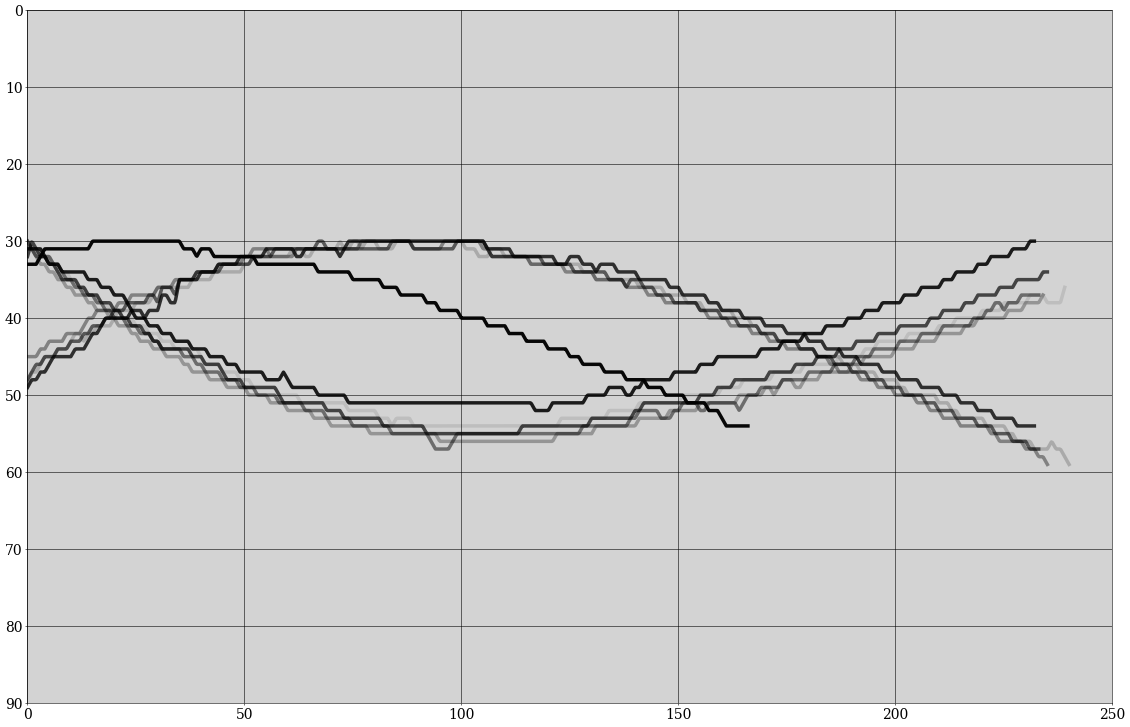

In [134]:
for i in np.arange(len(plate))[::50]:
    x,y = np.where(plate[i]!=0)
    alph = i/len(plate)
    ys = np.linspace(min(y),max(y),1000)
    f = interp1d(y,x)
    xs = f(ys)
    plt.plot(ys,xs, color='k', lw=5, alpha=alph)

plt.xlim(0,250)
plt.ylim(90,0)

(90.0, 0.0)

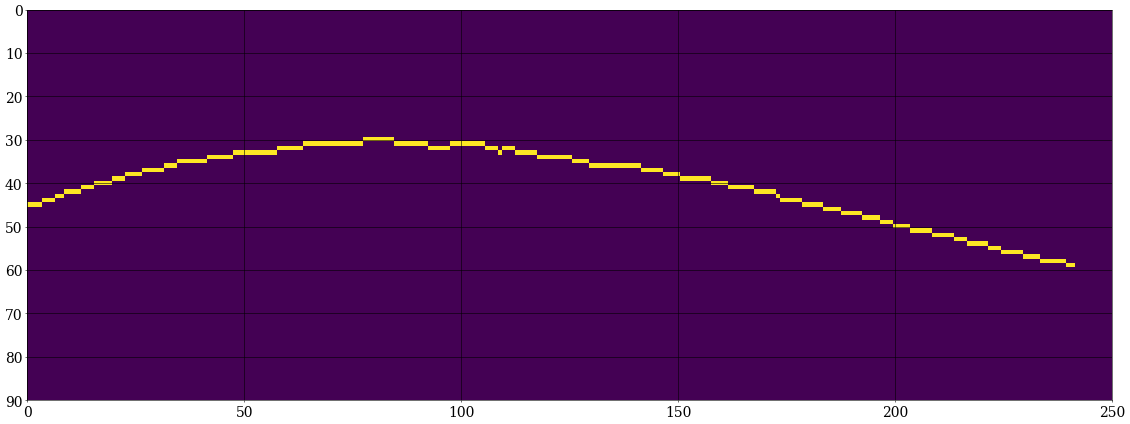

In [58]:
plt.imshow(plate[0])
plt.xlim(0,250)
plt.ylim(90,0)

#### Encontrando amplitud de cola en fn del tiempo

(90.0, 0.0)

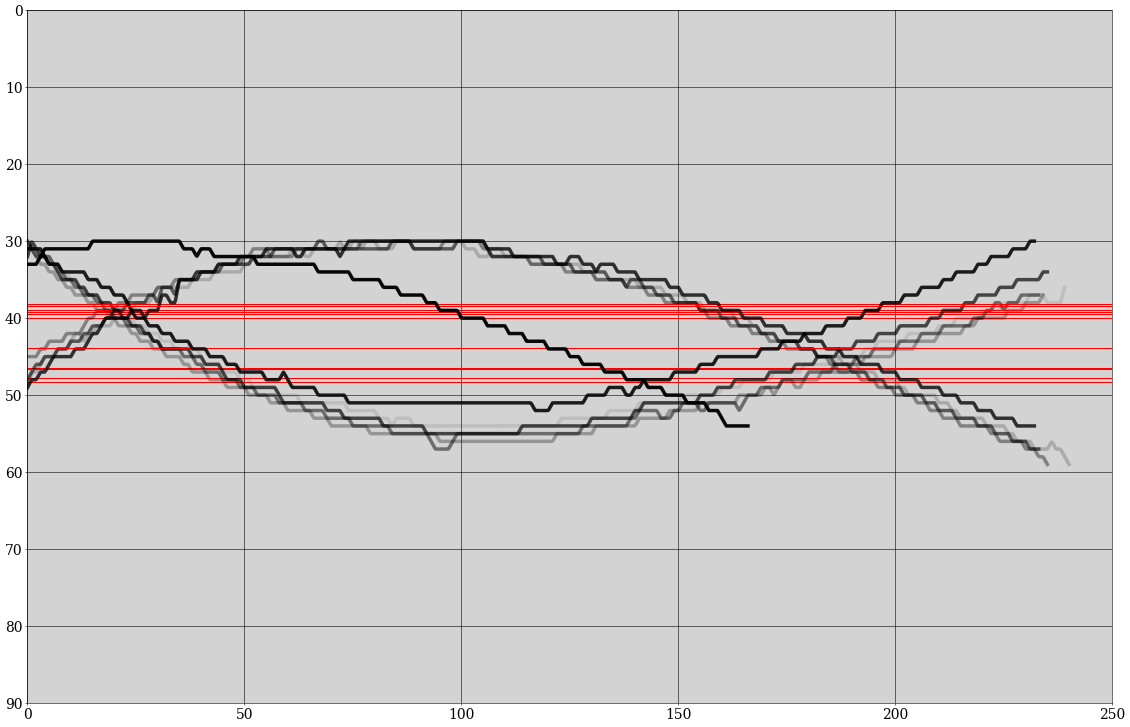

In [29]:
for i in np.arange(len(plate))[::50]:
    y,x = np.where(plate[i]!=0)
    alph = i/len(plate)
    avg_y = np.mean(y)
    xs = np.linspace(min(x),max(x),1000)
    f = interp1d(x,y)
    ys = f(xs)
    plt.axhline(avg_y,color='r')
    plt.plot(xs,ys, color='k', lw=5, alpha=alph)

plt.xlim(0,250)
plt.ylim(90,0)

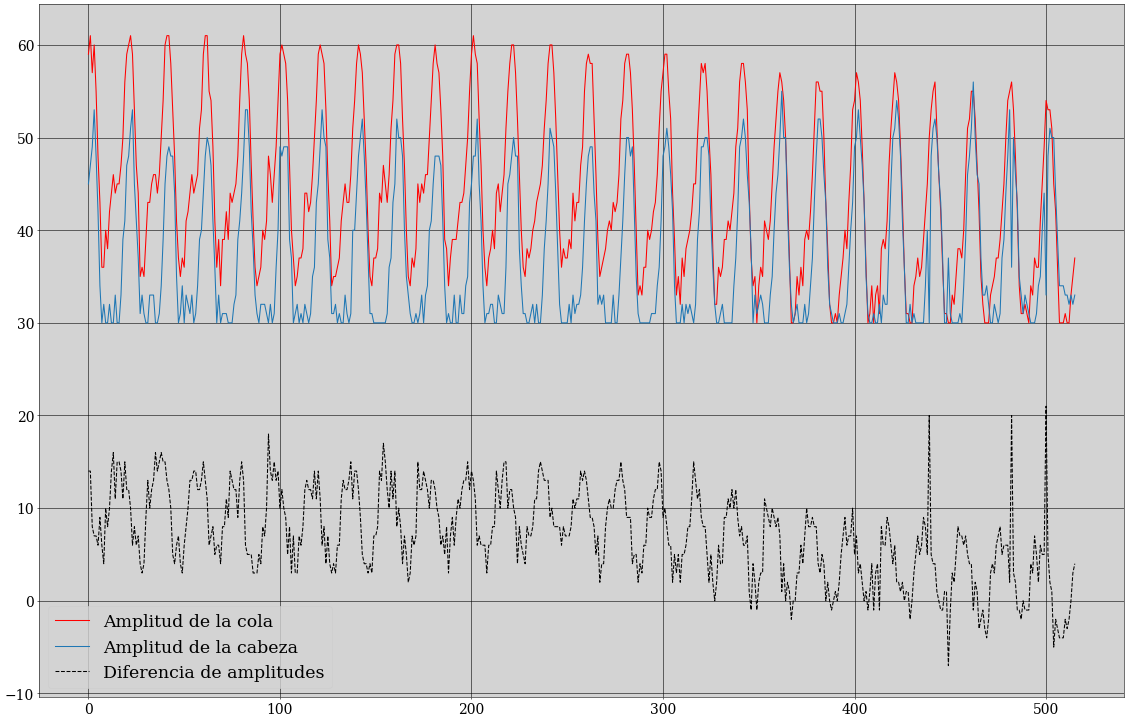

In [52]:
tail_amplitude = np.zeros(len(plate))
head_amplitude = np.zeros(len(plate))

for i in np.arange(len(plate)):
    y,x = np.where(plate[i]!=0)
    head_index = np.argmin(x)
    head = y[head_index]
    tail_index = np.argmax(x)
    tail = y[tail_index]
    head_amplitude[i] = head
    tail_amplitude[i] = tail    

fig,ax = plt.subplots()
plt.plot(tail_amplitude, color='r', label='Amplitud de la cola')
plt.plot(head_amplitude, color='tab:blue', label='Amplitud de la cabeza')
plt.plot(tail_amplitude - head_amplitude, color='k', ls='--', label='Diferencia de amplitudes')
plt.legend()
#plt.xlim(0,300)

### Maquina de hacer datos de (x,y,t) para cada video

#### Para la cabeza

In [55]:
import os

for filename in os.listdir('videos'):
    spl = filename.split('.')[0].split('-')
    v,f = spl[2],spl[3]
    video = cv.VideoCapture('videos/'+filename)
    lim = [319, 950, 250, 505] #[xleft, xright, ytop, ydown]
    t,x,y = tracker(video, lim, SHOW=False)

    # Guardo los datos
    pd.DataFrame().assign(t=t[:len(x)]).assign(x=x).assign(y=y).to_csv(f'ECO20-45mm/cabeza/{v}-{f}.csv')
    
    # # Graficos de debuggeo
    # fig, [ax1, ax2] = plt.subplots(1, 2)

    # fig.suptitle(f'{v} ; {f}')
    
    # ax1.plot(x, y, '.')
    # ax2.plot(t[:len(x)], x, '.',label='x')
    # ax2.plot(t[:len(x)], y, '.', label='y')
    # ax2.legend()

#### Para el final de la cola

In [147]:
import os

for filename in os.listdir('videos'):
    spl = filename.split('.')[0].split('-')
    v,f = spl[2],spl[3]
    video = cv.VideoCapture('videos/'+filename)
    #lim = [319, 950, 250, 505] #[xleft, xright, ytop, ydown]
    lim = [310, 950, 250, 505] #[xleft, xright, ytop, ydown]
    
    t,x,y = track_TAIL(video, lim, SHOW=False)

    if x.size>0:
    # Guardo los datos
        pd.DataFrame().assign(t=t[:len(x)]).assign(x=x).assign(y=y).to_csv(f'ECO20-45mm/fin_cola/{v}-{f}.csv')
    else:
        print(filename)
        t,x,y = track_TAIL(video, lim, SHOW=True)
    # # Graficos de debuggeo
    # fig, [ax1, ax2] = plt.subplots(1, 2)

    # fig.suptitle(f'{v} ; {f}')
    
    # ax1.plot(x, y, '.')
    # ax2.plot(t[:len(x)], x, '.',label='x')
    # ax2.plot(t[:len(x)], y, '.', label='y')
    # ax2.legend()